In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])

In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

72

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: xgb.DMatrix):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: DMatrix dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0]

In [9]:
model_params = {
    "tree_method":"hist",
    "grow_policy":"depthwise",
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'seed': 19,
    'verbosity': 1,
    'max_depth':7,
    'max_bin':256,
    'colsample_bytree':0.3,
    'subsample':0.9,
    'reg_alpha':1,
    'reg_lambda':0.1,
    'min_child_weight':1000,
}

[0]	valid-rmse:1.02563	valid-pearsonr:0.08699


[20]	valid-rmse:0.91469	valid-pearsonr:0.12433


[40]	valid-rmse:0.89890	valid-pearsonr:0.13009


[60]	valid-rmse:0.89655	valid-pearsonr:0.13123


[80]	valid-rmse:0.89596	valid-pearsonr:0.13224


[100]	valid-rmse:0.89563	valid-pearsonr:0.13361


[120]	valid-rmse:0.89545	valid-pearsonr:0.13409


[140]	valid-rmse:0.89534	valid-pearsonr:0.13421


[160]	valid-rmse:0.89520	valid-pearsonr:0.13480


[180]	valid-rmse:0.89504	valid-pearsonr:0.13570


[200]	valid-rmse:0.89500	valid-pearsonr:0.13566


[220]	valid-rmse:0.89491	valid-pearsonr:0.13613


[240]	valid-rmse:0.89487	valid-pearsonr:0.13632


[260]	valid-rmse:0.89476	valid-pearsonr:0.13705


[280]	valid-rmse:0.89473	valid-pearsonr:0.13719


[300]	valid-rmse:0.89466	valid-pearsonr:0.13766


[320]	valid-rmse:0.89465	valid-pearsonr:0.13768


[340]	valid-rmse:0.89462	valid-pearsonr:0.13791


[360]	valid-rmse:0.89459	valid-pearsonr:0.13815


[380]	valid-rmse:0.89455	valid-pearsonr:0.13848


[400]	valid-rmse:0.89450	valid-pearsonr:0.13891


[420]	valid-rmse:0.89446	valid-pearsonr:0.13922


[440]	valid-rmse:0.89444	valid-pearsonr:0.13945


[460]	valid-rmse:0.89440	valid-pearsonr:0.13975


[480]	valid-rmse:0.89439	valid-pearsonr:0.13991


[500]	valid-rmse:0.89438	valid-pearsonr:0.14003


[520]	valid-rmse:0.89443	valid-pearsonr:0.13974


[540]	valid-rmse:0.89437	valid-pearsonr:0.14031


[560]	valid-rmse:0.89435	valid-pearsonr:0.14051


[580]	valid-rmse:0.89432	valid-pearsonr:0.14078


[600]	valid-rmse:0.89434	valid-pearsonr:0.14072


[620]	valid-rmse:0.89434	valid-pearsonr:0.14084


[640]	valid-rmse:0.89441	valid-pearsonr:0.14046


[660]	valid-rmse:0.89437	valid-pearsonr:0.14082


[662]	valid-rmse:0.89437	valid-pearsonr:0.14087


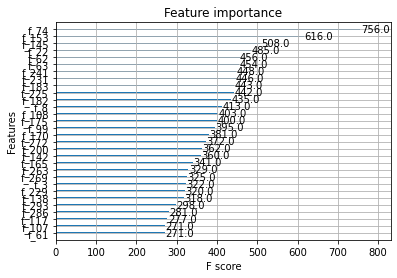

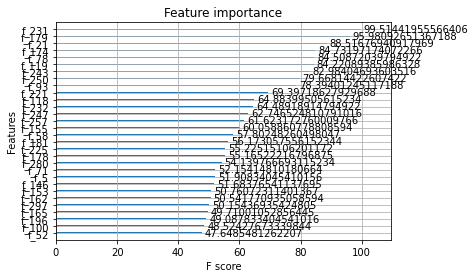

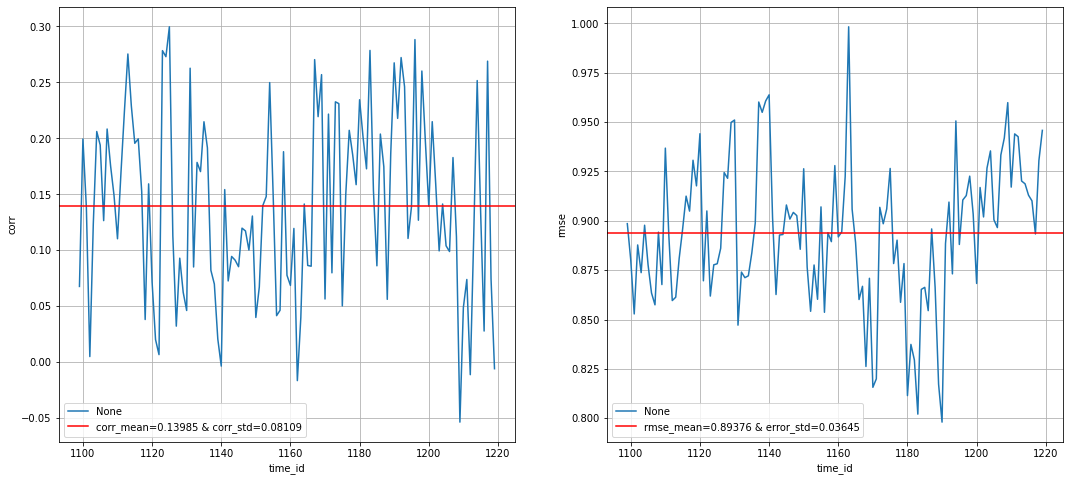

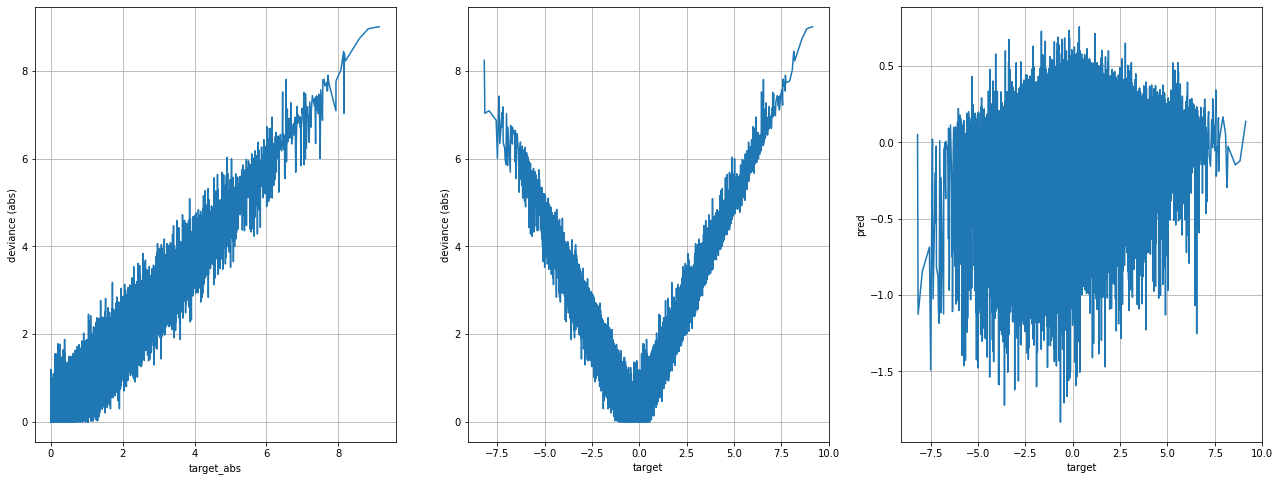

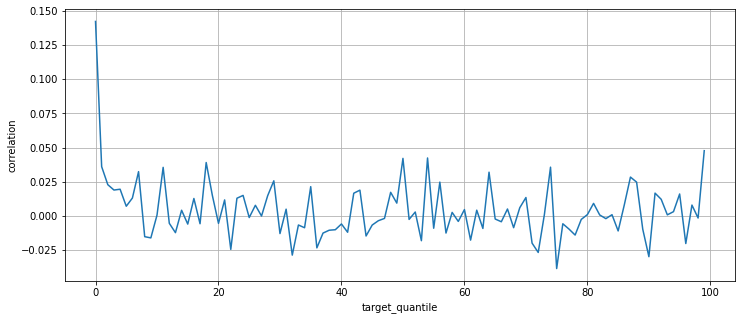

[0]	valid-rmse:1.02957	valid-pearsonr:0.08098


[20]	valid-rmse:0.92104	valid-pearsonr:0.11018


[40]	valid-rmse:0.90627	valid-pearsonr:0.11783


[60]	valid-rmse:0.90403	valid-pearsonr:0.12341


[80]	valid-rmse:0.90335	valid-pearsonr:0.12742


[100]	valid-rmse:0.90294	valid-pearsonr:0.13029


[120]	valid-rmse:0.90264	valid-pearsonr:0.13209


[140]	valid-rmse:0.90232	valid-pearsonr:0.13419


[160]	valid-rmse:0.90212	valid-pearsonr:0.13524


[180]	valid-rmse:0.90194	valid-pearsonr:0.13612


[200]	valid-rmse:0.90178	valid-pearsonr:0.13705


[220]	valid-rmse:0.90163	valid-pearsonr:0.13790


[240]	valid-rmse:0.90156	valid-pearsonr:0.13816


[260]	valid-rmse:0.90151	valid-pearsonr:0.13827


[280]	valid-rmse:0.90148	valid-pearsonr:0.13835


[300]	valid-rmse:0.90146	valid-pearsonr:0.13839


[307]	valid-rmse:0.90145	valid-pearsonr:0.13842


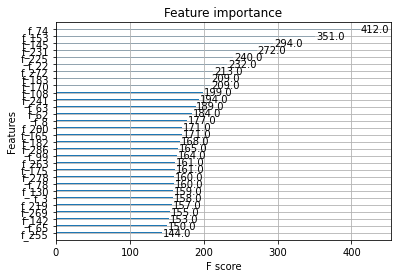

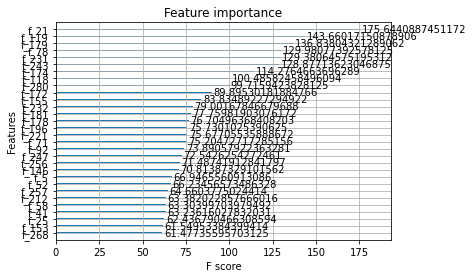

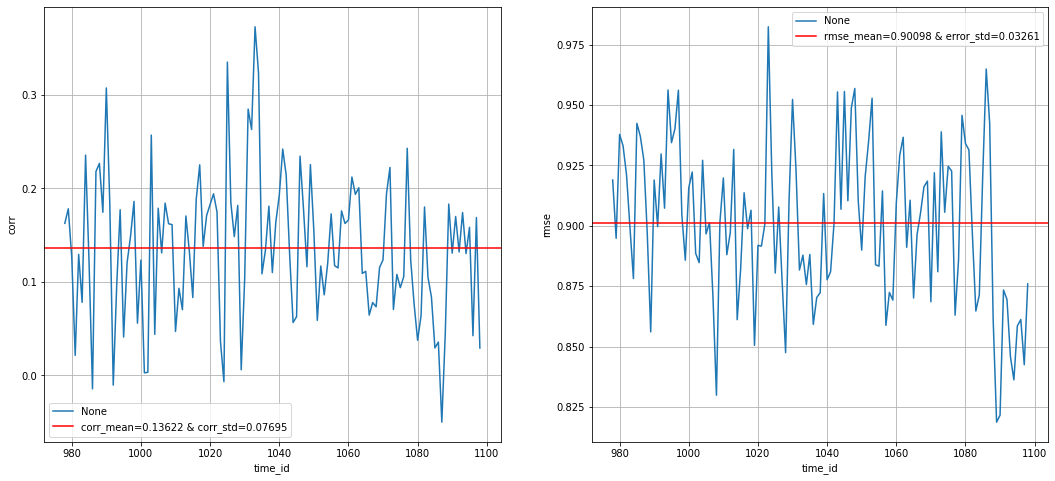

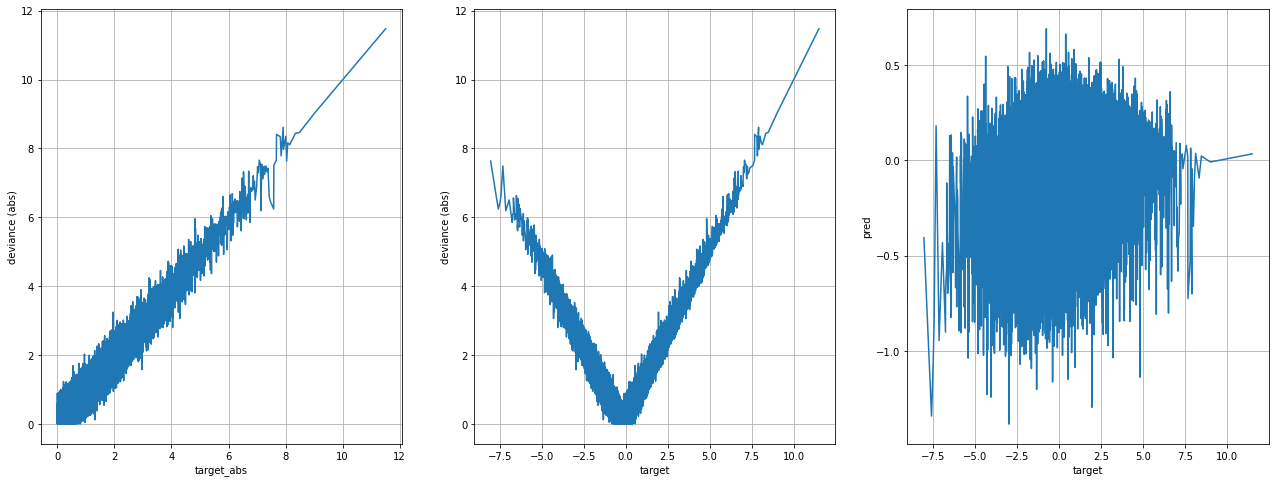

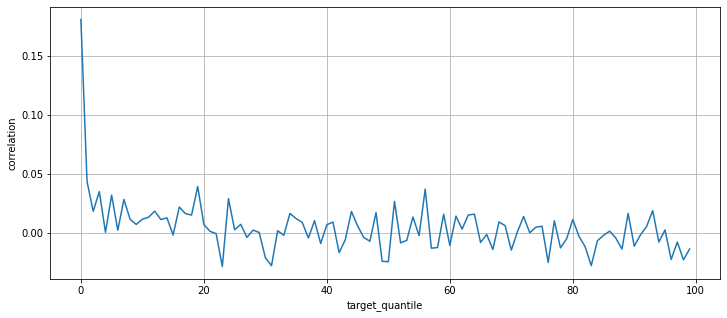

[0]	valid-rmse:1.06132	valid-pearsonr:0.06977


[20]	valid-rmse:0.95471	valid-pearsonr:0.09547


[40]	valid-rmse:0.94061	valid-pearsonr:0.10251


[60]	valid-rmse:0.93854	valid-pearsonr:0.10901


[80]	valid-rmse:0.93803	valid-pearsonr:0.11253


[100]	valid-rmse:0.93765	valid-pearsonr:0.11586


[120]	valid-rmse:0.93736	valid-pearsonr:0.11817


[140]	valid-rmse:0.93708	valid-pearsonr:0.12038


[160]	valid-rmse:0.93682	valid-pearsonr:0.12247


[180]	valid-rmse:0.93664	valid-pearsonr:0.12385


[200]	valid-rmse:0.93642	valid-pearsonr:0.12560


[220]	valid-rmse:0.93624	valid-pearsonr:0.12698


[240]	valid-rmse:0.93602	valid-pearsonr:0.12873


[260]	valid-rmse:0.93594	valid-pearsonr:0.12925


[280]	valid-rmse:0.93584	valid-pearsonr:0.13003


[300]	valid-rmse:0.93573	valid-pearsonr:0.13083


[320]	valid-rmse:0.93569	valid-pearsonr:0.13121


[340]	valid-rmse:0.93562	valid-pearsonr:0.13177


[360]	valid-rmse:0.93555	valid-pearsonr:0.13232


[380]	valid-rmse:0.93550	valid-pearsonr:0.13277


[400]	valid-rmse:0.93546	valid-pearsonr:0.13303


[420]	valid-rmse:0.93541	valid-pearsonr:0.13349


[440]	valid-rmse:0.93538	valid-pearsonr:0.13380


[460]	valid-rmse:0.93536	valid-pearsonr:0.13400


[480]	valid-rmse:0.93534	valid-pearsonr:0.13425


[500]	valid-rmse:0.93532	valid-pearsonr:0.13447


[520]	valid-rmse:0.93524	valid-pearsonr:0.13520


[540]	valid-rmse:0.93520	valid-pearsonr:0.13556


[560]	valid-rmse:0.93512	valid-pearsonr:0.13622


[580]	valid-rmse:0.93513	valid-pearsonr:0.13624


[600]	valid-rmse:0.93510	valid-pearsonr:0.13659


[620]	valid-rmse:0.93512	valid-pearsonr:0.13656


[640]	valid-rmse:0.93510	valid-pearsonr:0.13675


[660]	valid-rmse:0.93511	valid-pearsonr:0.13680


[680]	valid-rmse:0.93507	valid-pearsonr:0.13715


[700]	valid-rmse:0.93506	valid-pearsonr:0.13736


[720]	valid-rmse:0.93505	valid-pearsonr:0.13750


[740]	valid-rmse:0.93505	valid-pearsonr:0.13760


[760]	valid-rmse:0.93505	valid-pearsonr:0.13775


[780]	valid-rmse:0.93504	valid-pearsonr:0.13796


[800]	valid-rmse:0.93509	valid-pearsonr:0.13777


[820]	valid-rmse:0.93509	valid-pearsonr:0.13787


[840]	valid-rmse:0.93510	valid-pearsonr:0.13790


[860]	valid-rmse:0.93510	valid-pearsonr:0.13809


[880]	valid-rmse:0.93508	valid-pearsonr:0.13830


[900]	valid-rmse:0.93509	valid-pearsonr:0.13836


[920]	valid-rmse:0.93510	valid-pearsonr:0.13840


[940]	valid-rmse:0.93511	valid-pearsonr:0.13848


[960]	valid-rmse:0.93511	valid-pearsonr:0.13855


[980]	valid-rmse:0.93516	valid-pearsonr:0.13838


[1000]	valid-rmse:0.93519	valid-pearsonr:0.13834


[1006]	valid-rmse:0.93519	valid-pearsonr:0.13832


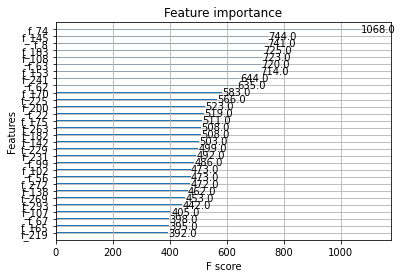

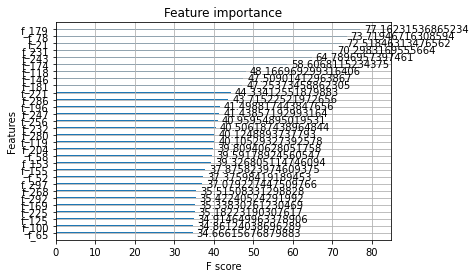

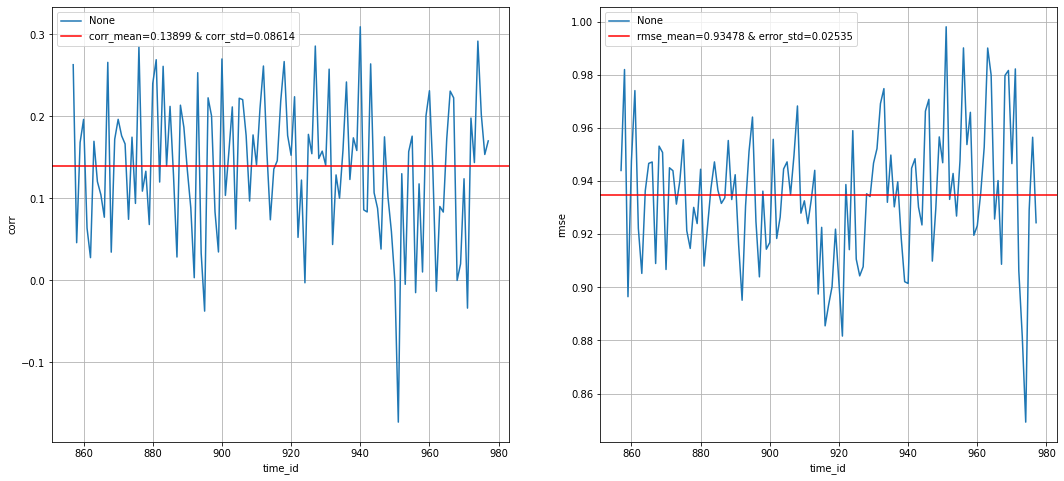

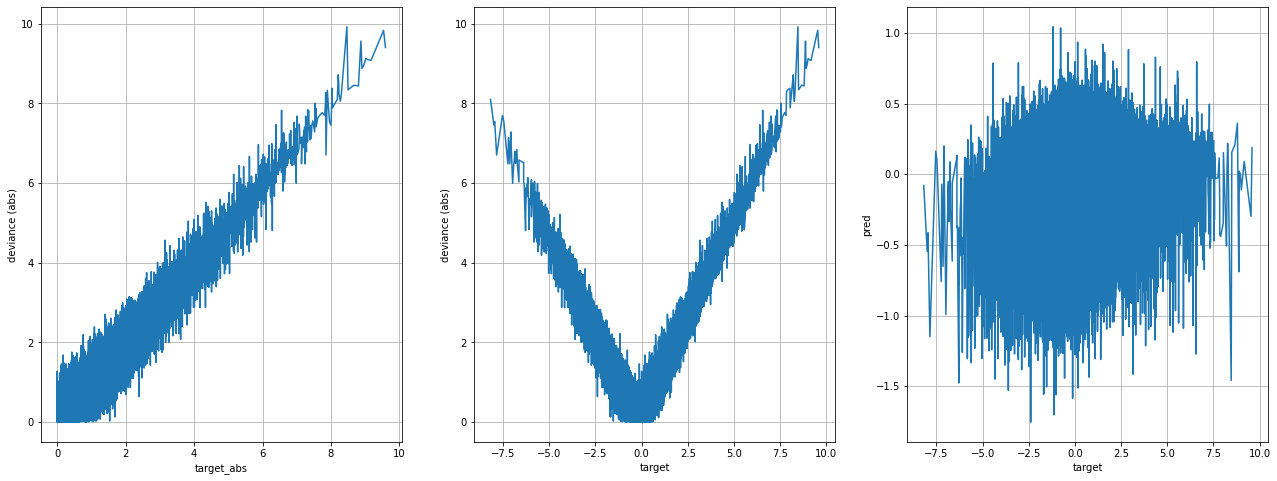

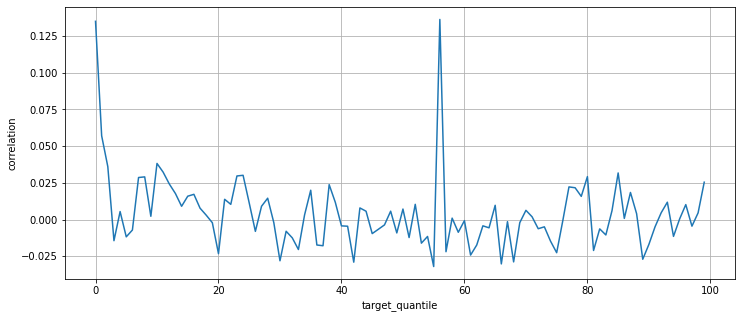

n_iterations: 608
CPU times: user 5h 54min 58s, sys: 19min 45s, total: 6h 14min 44s
Wall time: 31min 57s


In [10]:
%%time

pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:
        
        # input datasets for xgb
        train_dset = xgb.DMatrix(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
        )
        valid_dset = xgb.DMatrix(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
        )
        
        model = xgb.train(
            params=model_params,
            num_boost_round=3000,
            dtrain=train_dset,
            evals=[(valid_dset,"valid"),],
            feval=pearsonr,
            maximize=True,
            early_stopping_rounds=50,
            verbose_eval=20,
        )
        models.append(model)

        xgb.plot_importance(model, importance_type="weight", max_num_features=30)
        xgb.plot_importance(model, importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(valid_dset)
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
        
        ## correlation vs target value
        oof["target_pct"] = ((100-1e-10)*oof.target.rank(pct=True)).astype(int)
        #oof["target_pct"] = 5*(oof.target_pct/5).astype(int)

        bucket_corr = (
            oof
            .groupby("target_pct")
            .apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
            .reset_index()
            .rename({0:"corr"}, axis=1)
        )

        plt.figure(figsize=(12,5))
        plt.plot(bucket_corr["target_pct"], bucket_corr["corr"])
        plt.xlabel("target_quantile")
        plt.ylabel("correlation")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # default value
    n_iterations = 600
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.13984848191551247, 0.13622381484168533, 0.13898938167552846],
 'corr_std': [0.08109231214063296, 0.0769451322155063, 0.0861369345827728],
 'error_mean': [0.8937583047141087, 0.9009826143234542, 0.9347837432631514],
 'error_std': [0.0364468585059442, 0.03261429808384798, 0.025353547773072]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.13835389281090874

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9098415541002381

***
## model training

[0]	train-rmse:1.04401	train-pearsonr:0.10522


[50]	train-rmse:0.91087	train-pearsonr:0.15998


[100]	train-rmse:0.90628	train-pearsonr:0.18554


[150]	train-rmse:0.90366	train-pearsonr:0.20229


[200]	train-rmse:0.90138	train-pearsonr:0.21620


[250]	train-rmse:0.89937	train-pearsonr:0.22789


[300]	train-rmse:0.89758	train-pearsonr:0.23786


[350]	train-rmse:0.89591	train-pearsonr:0.24696


[400]	train-rmse:0.89426	train-pearsonr:0.25576


[450]	train-rmse:0.89267	train-pearsonr:0.26396


[500]	train-rmse:0.89111	train-pearsonr:0.27188


[550]	train-rmse:0.88964	train-pearsonr:0.27909


[600]	train-rmse:0.88826	train-pearsonr:0.28586


[607]	train-rmse:0.88806	train-pearsonr:0.28680


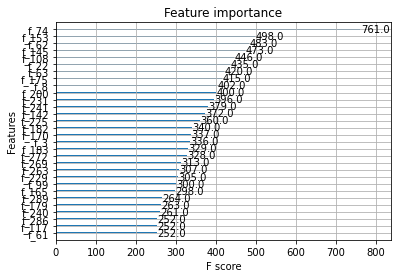

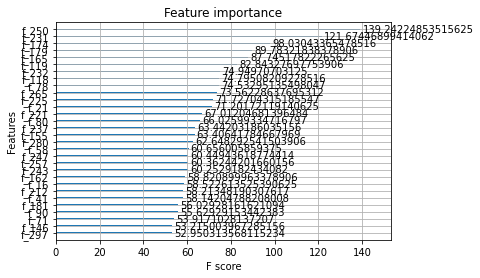

[0]	train-rmse:1.04401	train-pearsonr:0.10522


[50]	train-rmse:0.91087	train-pearsonr:0.15998


[100]	train-rmse:0.90628	train-pearsonr:0.18554


[150]	train-rmse:0.90366	train-pearsonr:0.20229


[200]	train-rmse:0.90138	train-pearsonr:0.21620


[250]	train-rmse:0.89937	train-pearsonr:0.22789


[300]	train-rmse:0.89758	train-pearsonr:0.23786


[350]	train-rmse:0.89591	train-pearsonr:0.24696


[400]	train-rmse:0.89426	train-pearsonr:0.25576


[450]	train-rmse:0.89267	train-pearsonr:0.26396


[500]	train-rmse:0.89111	train-pearsonr:0.27188


[550]	train-rmse:0.88964	train-pearsonr:0.27909


[600]	train-rmse:0.88826	train-pearsonr:0.28586


[607]	train-rmse:0.88806	train-pearsonr:0.28680


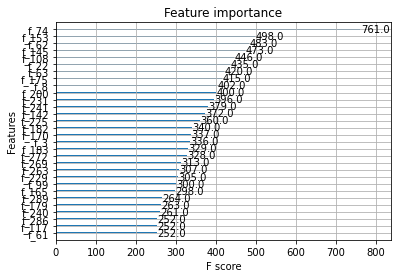

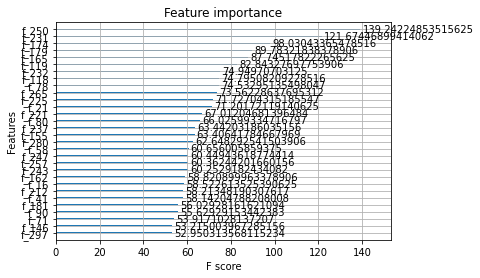

[0]	train-rmse:1.04401	train-pearsonr:0.10522


[50]	train-rmse:0.91087	train-pearsonr:0.15998


[100]	train-rmse:0.90628	train-pearsonr:0.18554


[150]	train-rmse:0.90366	train-pearsonr:0.20229


[200]	train-rmse:0.90138	train-pearsonr:0.21620


[250]	train-rmse:0.89937	train-pearsonr:0.22789


[300]	train-rmse:0.89758	train-pearsonr:0.23786


[350]	train-rmse:0.89591	train-pearsonr:0.24696


[400]	train-rmse:0.89426	train-pearsonr:0.25576


[450]	train-rmse:0.89267	train-pearsonr:0.26396


[500]	train-rmse:0.89111	train-pearsonr:0.27188


[550]	train-rmse:0.88964	train-pearsonr:0.27909


[600]	train-rmse:0.88826	train-pearsonr:0.28586


[607]	train-rmse:0.88806	train-pearsonr:0.28680


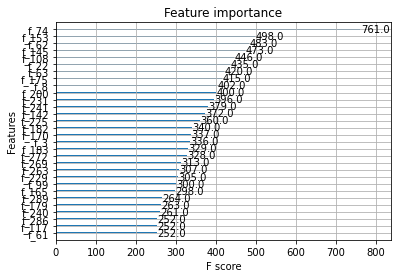

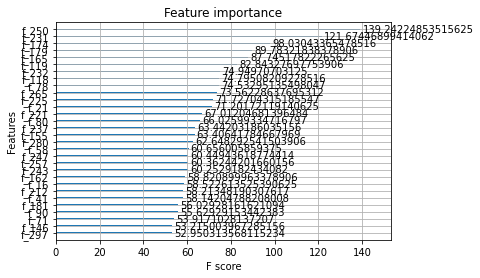

[0]	train-rmse:1.04401	train-pearsonr:0.10522


[50]	train-rmse:0.91087	train-pearsonr:0.15998


[100]	train-rmse:0.90628	train-pearsonr:0.18554


[150]	train-rmse:0.90366	train-pearsonr:0.20229


[200]	train-rmse:0.90138	train-pearsonr:0.21620


[250]	train-rmse:0.89937	train-pearsonr:0.22789


[300]	train-rmse:0.89758	train-pearsonr:0.23786


[350]	train-rmse:0.89591	train-pearsonr:0.24696


[400]	train-rmse:0.89426	train-pearsonr:0.25576


[450]	train-rmse:0.89267	train-pearsonr:0.26396


[500]	train-rmse:0.89111	train-pearsonr:0.27188


[550]	train-rmse:0.88964	train-pearsonr:0.27909


[600]	train-rmse:0.88826	train-pearsonr:0.28586


[607]	train-rmse:0.88806	train-pearsonr:0.28680


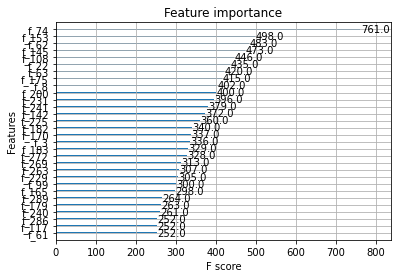

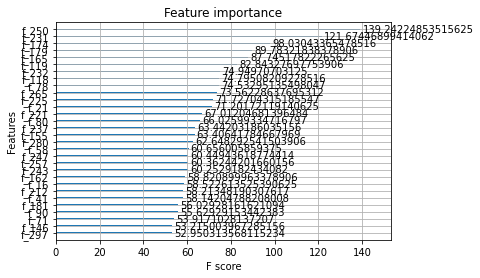

[0]	train-rmse:1.04401	train-pearsonr:0.10522


[50]	train-rmse:0.91087	train-pearsonr:0.15998


[100]	train-rmse:0.90628	train-pearsonr:0.18554


[150]	train-rmse:0.90366	train-pearsonr:0.20229


[200]	train-rmse:0.90138	train-pearsonr:0.21620


[250]	train-rmse:0.89937	train-pearsonr:0.22789


[300]	train-rmse:0.89758	train-pearsonr:0.23786


[350]	train-rmse:0.89591	train-pearsonr:0.24696


[400]	train-rmse:0.89426	train-pearsonr:0.25576


[450]	train-rmse:0.89267	train-pearsonr:0.26396


[500]	train-rmse:0.89111	train-pearsonr:0.27188


[550]	train-rmse:0.88964	train-pearsonr:0.27909


[600]	train-rmse:0.88826	train-pearsonr:0.28586


[607]	train-rmse:0.88806	train-pearsonr:0.28680


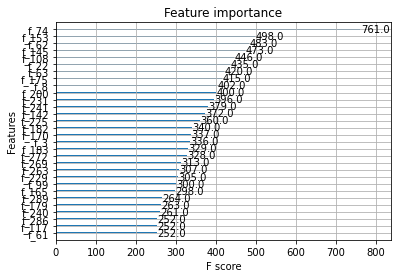

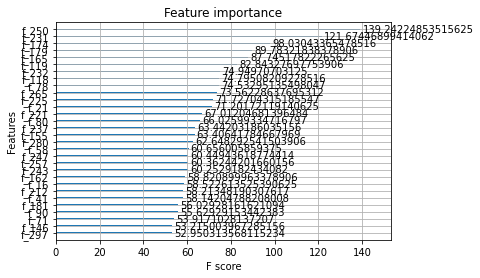

In [14]:
seeds = [2,7,11,19,23]
models = list()

train_dset = xgb.DMatrix(
    data=features,
    label=target.target.values,
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    
    model = xgb.train(
        params=model_params,
        num_boost_round=n_iterations,
        dtrain=train_dset,
        evals=[(train_dset,"train"),],
        feval=pearsonr,
        maximize=True,
        verbose_eval=50,
    )
    models.append(model)

    xgb.plot_importance(model, importance_type="weight", max_num_features=30)
    xgb.plot_importance(model, importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/xgboost-gbrt/xgb-seed{seed}.json")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***